In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import mplotutils as mpu
from netCDF4 import Dataset
import metpy.calc as mpcalc
from metpy.units import units
from datetime import datetime
import matplotlib.pyplot as plt
from wrf import getvar, ll_to_xy, to_np
from metpy.plots import Hodograph, SkewT
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

# Skew T - log p Diagram

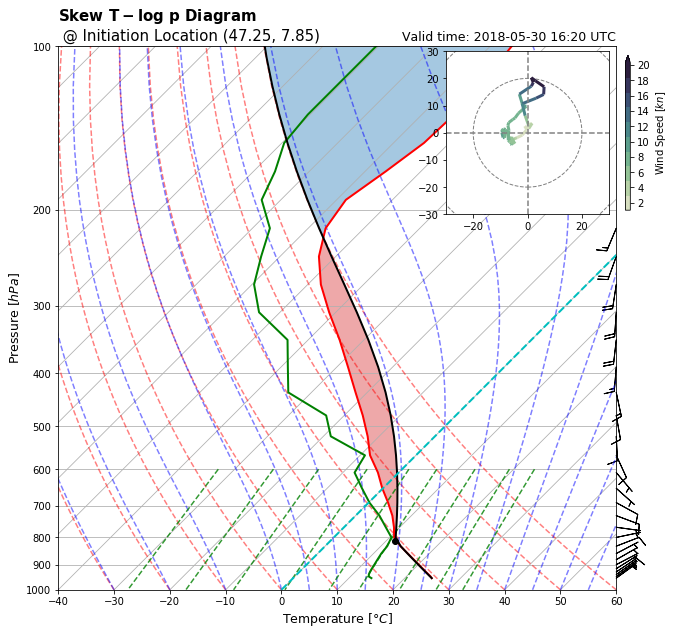

In [3]:
### Predefine some variables ###
date = datetime(2018, 5, 30, 16, 20)
lat = 47.25
lon = 7.85
filename = '/scratch3/thomasl/work/data/locations/wrfout_d02_2018-05-30_16:20:00'
save = False

### Plotting procedure ###
# Get computed variables by wrf-python
ncfile = Dataset(filename)

pressure = getvar(ncfile, 'pressure')
height = getvar(ncfile, 'height')
temperature = getvar(ncfile, 'tc')
dewpoint = getvar(ncfile, 'td')
wspd = getvar(ncfile, 'wspd_wdir')[0,:]
wdir = getvar(ncfile, 'wspd_wdir')[1,:]

# Add computed variables to dataset
ds = xr.open_dataset(filename)

ds['pressure'] = (['bottom_top', 'south_north', 'west_east'], pressure)
ds['height'] = (['bottom_top', 'south_north', 'west_east'], height)
ds['temperature'] = (['bottom_top', 'south_north', 'west_east'], temperature)
ds['dewpoint'] = (['bottom_top', 'south_north', 'west_east'], dewpoint)
ds['wspd'] = (['bottom_top', 'south_north', 'west_east'], wspd)
ds['wdir'] = (['bottom_top', 'south_north', 'west_east'], wdir)

# Select location of sounding
x_y = ll_to_xy(ncfile, lat, lon)

ds_point = ds.sel(west_east=x_y[0], south_north=x_y[1])

# Get variables for location
p = ds_point['pressure'].values * units.hPa
T = ds_point['temperature'].values * units.degC
Td = ds_point['dewpoint'].values * units.degC
wind_speed = ds_point['wspd'].values * units.knots
wind_dir = ds_point['wdir'].values * units.degrees

# Limit pressure level for wind barbs
p_200 = ds_point['pressure']
p_200 = p_200.where(p_200 > 200)
p_200 = p_200.values * units.hPa

# Calculate wind components
u, v = mpcalc.wind_components(wind_speed, wind_dir)

# Calculate the LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])

# Calculate the parcel profile.
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

# Create figure
fig = plt.figure(figsize=(10, 10))
skew = SkewT(fig, rotation=45)

# Plot the data
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'g', linewidth=2)
skew.plot_barbs(p_200, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Create a hodograph
ax_hod = inset_axes(skew.ax, '30%', '30%', loc=1)
h = Hodograph(ax_hod, component_range=30.)
h.add_grid(increment=20)

# Add wind speed colored line 
cmap = ListedColormap(sns.cubehelix_palette(10, start=.5, rot=-.75))
levels = np.linspace(0, 20, 11)
wind_speed_h = h.plot_colormapped(u, v, wind_speed, intervals=levels, cmap=cmap)

# Add color bar for hodograph
cbar_h = mpu.colorbar(wind_speed_h, ax_hod, orientation='vertical', 
                      aspect=30, shrink=.05, pad=0.1, extend='max')
cbar_h.set_label('Wind Speed [$kn$]', fontsize=10)
cbar_h.set_ticks(levels)

# Set label of axes
skew.ax.set_ylabel('Pressure [$hPa$]', fontsize=12.5)
skew.ax.set_xlabel('Temperature [$°C$]', fontsize=12.5)

# Make nicetime
nicetime = pd.to_datetime(date)

# Add title
skew.ax.set_title('')
skew.ax.set_title('Valid time: {} UTC'.format(nicetime.strftime('%Y-%m-%d %H:%M')), 
                  loc='right', fontsize=12.5);
skew.ax.set_title(r'$\mathbf{Skew\ T-log\ p\ Diagram}$' + '\n @ Initiation Location ({}, {})'.format(lat, lon),
                  loc='left', fontsize=15)

plt.show()

# Save figure
if save == True:
    fig.savefig('/scratch3/thomasl/work/retrospective_part/' \
                'casestudy_baden/sounding/sounding' \
                    '.pdf', bbox_inches='tight')